# Librairies and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
%matplotlib inline

from ncaam.src.dao.loader import Loader

In [2]:
loader = Loader()

In [3]:
data = loader.import_data(["Cities", "Conferences", "MConferenceTourneyGames", "MGameCities",
                           "MMasseyOrdinals", "MNCAATourneyCompactResults", "MNCAATourneyDetailedResults",
                           "MNCAATourneySeedRoundSlots", "MNCAATourneySeeds", "MNCAATourneySlots",
                           "MRegularSeasonCompactResults", "MRegularSeasonDetailedResults", "MSeasons",
                           "MSecondaryTourneyCompactResults", "MSecondaryTourneyTeams", "MTeamCoaches",
                           "MTeamConferences", "MTeams", "MPlayers", "MEvents"])
data.keys()
# Il faut encore MTeamSpellings

dict_keys(['MEvents', 'MPlayers', 'MNCAATourneyDetailedResults', 'MNCAATourneyCompactResults', 'MSeasons', 'MRegularSeasonDetailedResults', 'MNCAATourneySlots', 'MGameCities', 'MConferenceTourneyGames', 'Cities', 'MRegularSeasonCompactResults', 'MNCAATourneySeedRoundSlots', 'MTeamConferences', 'MTeamCoaches', 'MMasseyOrdinals', 'Conferences', 'MTeams', 'MNCAATourneySeeds', 'MSecondaryTourneyTeams', 'MSecondaryTourneyCompactResults'])

In [4]:
MTeams = data["MTeams"]
MSeasons = data["MSeasons"]
MNCAATourneySeeds = data["MNCAATourneySeeds"]
MRegularSeasonCompactResults = data["MRegularSeasonCompactResults"]
MEvents = data["MEvents"]
MPlayers = data["MPlayers"]

# Regular Season Results

In [5]:
# Lets Add the winning and losing team names to the results
MRegularSeasonCompactResults = \
    MRegularSeasonCompactResults \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})

In [6]:
MRegularSeasonCompactResults['Score_Diff'] = MRegularSeasonCompactResults['WScore'] - MRegularSeasonCompactResults['LScore']

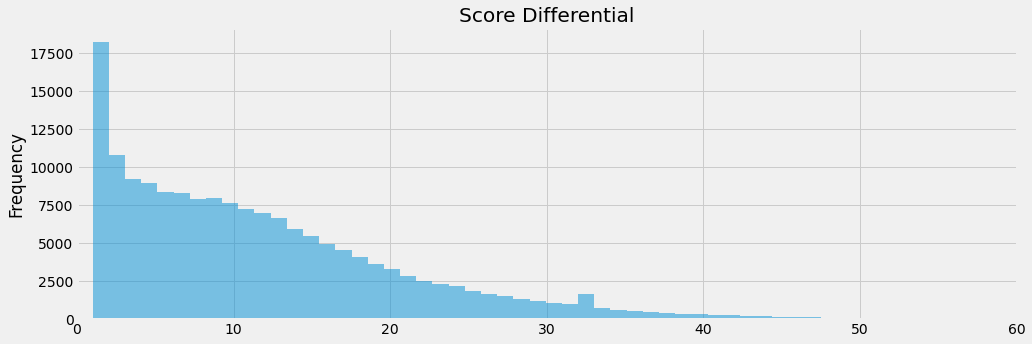

In [7]:
plt.style.use('fivethirtyeight')
MRegularSeasonCompactResults['Score_Diff'] \
    .plot(kind='hist',
          bins=90,
          figsize=(15, 5),
          alpha=0.5)

plt.title('Score Differential')
plt.xlim(0,60)
plt.show()

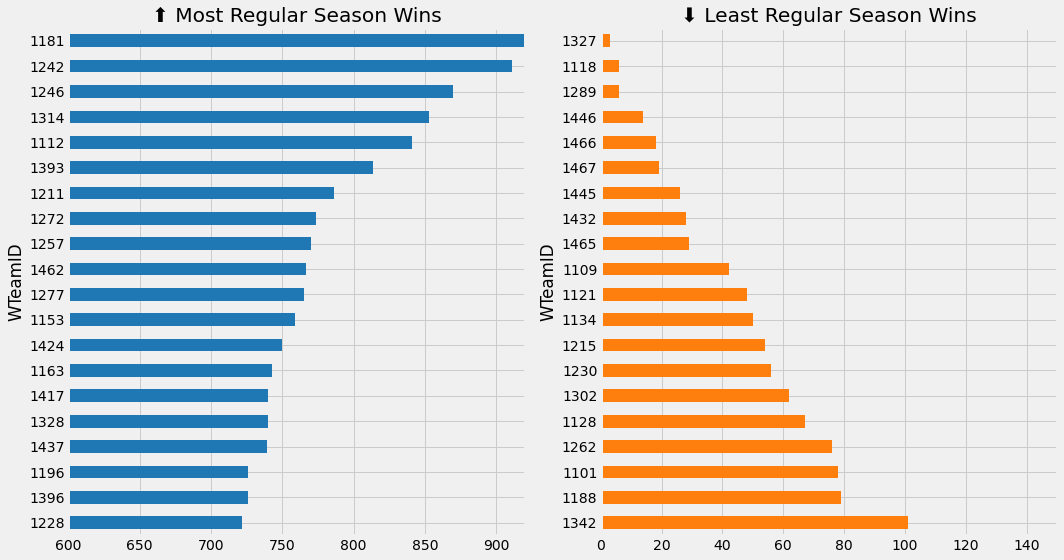

In [8]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MRegularSeasonCompactResults['counter'] = 1
MRegularSeasonCompactResults.groupby('WTeamID')['counter'] \
    .count() \
    .sort_values() \
    .tail(20) \
    .plot(kind='barh',
          title='⬆️ Most Regular Season Wins',
          figsize=(15, 8),
          xlim=(600, 920),
          color=mypal[0],
          ax=axs[0])
MRegularSeasonCompactResults.groupby('WTeamID')['counter'] \
    .count() \
    .sort_values(ascending=False) \
    .tail(20) \
    .plot(kind='barh',
          title='⬇️ Least Regular Season Wins',
          figsize=(15, 8),
          xlim=(0, 150),
          color=mypal[1],
          ax=axs[1])
plt.tight_layout()
plt.show()

# Event data

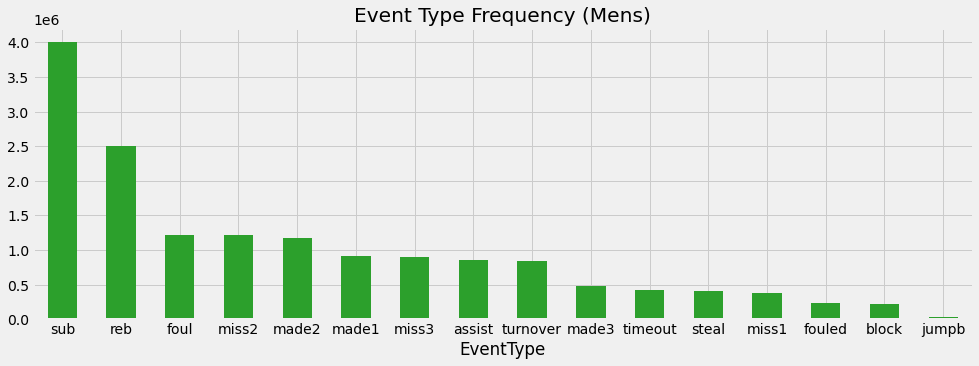

In [9]:
# Event Types
plt.style.use('fivethirtyeight')
MEvents['counter'] = 1
MEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='bar',
          figsize=(15, 5),
         color=mypal[2],
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()

In [10]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

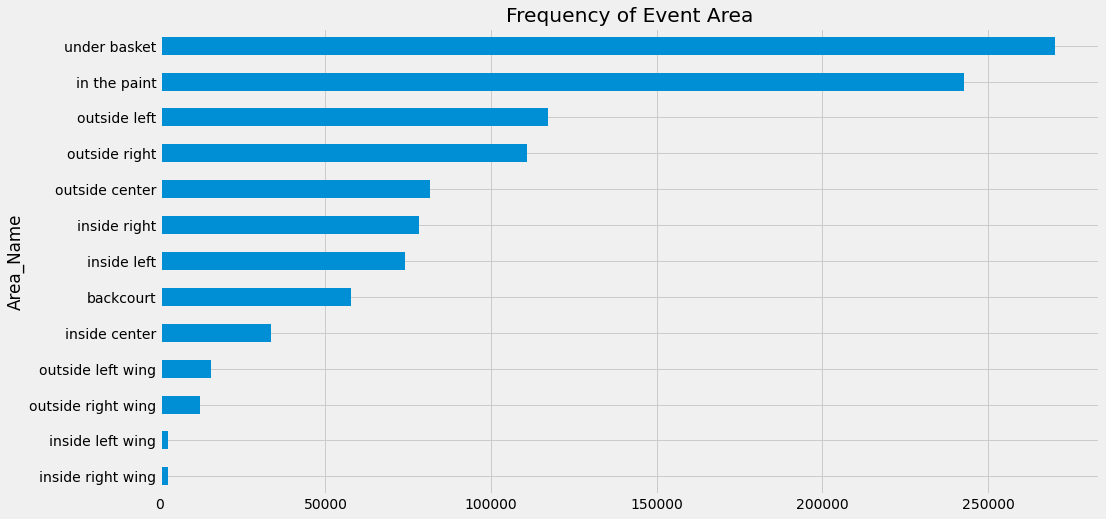

In [11]:
MEvents.groupby('Area_Name')['counter'].sum() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 8),
          title='Frequency of Event Area')
plt.show()

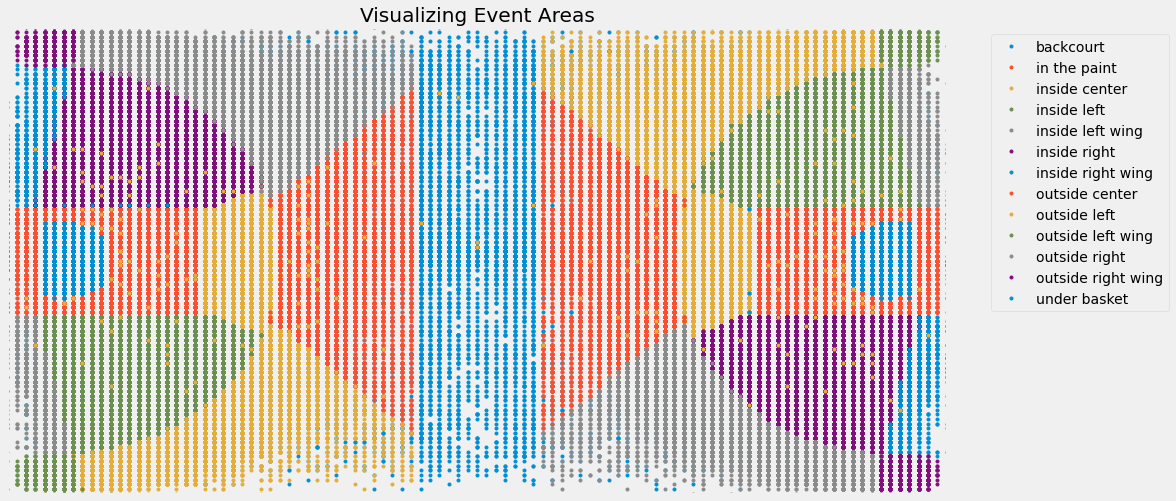

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, d in MEvents.loc[~MEvents['Area_Name'].isna()].groupby('Area_Name'):
    d.plot(x='X', y='Y', style='.', label=i, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="best")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

# NCAA Court Plot Function

In [13]:
# Normalize X, Y positions for court dimentions
# Court is 50 feet wide and 94 feet end to end.
MEvents['X'] = (MEvents['X'] * (94/100))
MEvents['Y'] = (MEvents['Y'] * (50/100))

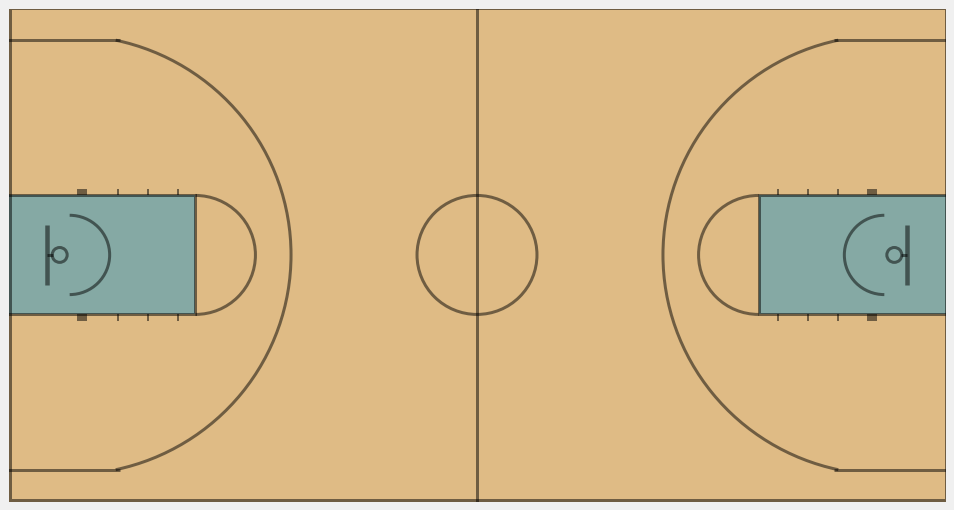

In [27]:
def create_ncaa_full_court(ax=None, three_line='mens', court_color='#dfbb85',
                           lw=3, lines_color='black', lines_alpha=0.5,
                           paint_fill='blue', paint_alpha=0.4,
                           inner_arc=False):
    """
    Version 2020.2.19
    Creates NCAA Basketball Court
    Dimensions are in feet (Court is 97x50 ft)
    Created by: Rob Mulla / https://github.com/RobMulla

    * Note that this function uses "feet" as the unit of measure.
    * NCAA Data is provided on a x range: 0, 100 and y-range 0 to 100
    * To plot X/Y positions first convert to feet like this:
    ```
    Events['X_'] = (Events['X'] * (94/100))
    Events['Y_'] = (Events['Y'] * (50/100))
    ```
    
    ax: matplotlib axes if None gets current axes using `plt.gca`


    three_line: 'mens', 'womens' or 'both' defines 3 point line plotted
    court_color : (hex) Color of the court
    lw : line width
    lines_color : Color of the lines
    lines_alpha : transparency of lines
    paint_fill : Color inside the paint
    paint_alpha : transparency of the "paint"
    inner_arc : paint the dotted inner arc
    """
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((94/2, 50/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
    hoop_left = Circle((5.25, 50/2), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)
    hoop_right = Circle((94-5.25, 50/2), 1.5 / 2,
                        linewidth=lw, color=lines_color, lw=lw,
                        fill=False, alpha=lines_alpha)

    # Paint - 18 Feet 10 inches which converts to 18.833333 feet - gross!
    left_paint = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    right_paint = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=paint_fill, alpha=paint_alpha,
                            lw=lw, edgecolor=None)
    
    left_paint_boarder = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=False, alpha=lines_alpha,
                           lw=lw, edgecolor=lines_color)
    right_paint_boarder = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=False, alpha=lines_alpha,
                            lw=lw, edgecolor=lines_color)

    left_arc = Arc((18.833333, 50/2), 12, 12, theta1=-
                   90, theta2=90, color=lines_color, lw=lw,
                   alpha=lines_alpha)
    right_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=90,
                    theta2=-90, color=lines_color, lw=lw,
                    alpha=lines_alpha)
    
    leftblock1 = Rectangle((7, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    leftblock2 = Rectangle((7, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(leftblock1)
    ax.add_patch(leftblock2)
    
    left_l1 = Rectangle((11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l2 = Rectangle((14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l3 = Rectangle((17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l1)
    ax.add_patch(left_l2)
    ax.add_patch(left_l3)
    left_l4 = Rectangle((11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l5 = Rectangle((14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l6 = Rectangle((17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l4)
    ax.add_patch(left_l5)
    ax.add_patch(left_l6)
    
    rightblock1 = Rectangle((94-7-1, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    rightblock2 = Rectangle((94-7-1, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(rightblock1)
    ax.add_patch(rightblock2)

    right_l1 = Rectangle((94-11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l2 = Rectangle((94-14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l3 = Rectangle((94-17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l1)
    ax.add_patch(right_l2)
    ax.add_patch(right_l3)
    right_l4 = Rectangle((94-11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l5 = Rectangle((94-14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l6 = Rectangle((94-17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l4)
    ax.add_patch(right_l5)
    ax.add_patch(right_l6)
    
    # 3 Point Line
    if (three_line == 'mens') | (three_line == 'both'):
        # 22' 1.75" distance to center of hoop
        three_pt_left = Arc((6.25, 50/2), 44.291, 44.291, theta1=-78,
                            theta2=78, color=lines_color, lw=lw,
                            alpha=lines_alpha)
        three_pt_right = Arc((94-6.25, 50/2), 44.291, 44.291,
                             theta1=180-78, theta2=180+78,
                             color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 feet max to sideline for mens
        ax.plot((0, 11.25), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((0, 11.25), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.add_patch(three_pt_left)
        ax.add_patch(three_pt_right)

    #if (three_line == 'womens') | (three_line == 'both'):
    #    # womens 3
    #    three_pt_left_w = Arc((6.25, 50/2), 20.75 * 2, 20.75 * 2, theta1=-85,
    #                          theta2=85, color=lines_color, lw=lw, alpha=lines_alpha)
    #    three_pt_right_w = Arc((94-6.25, 50/2), 20.75 * 2, 20.75 * 2,
    #                           theta1=180-85, theta2=180+85,
    #                           color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 inches max to sideline for mens
        #ax.plot((0, 8.3), (4.25, 4.25), color=lines_color,
        #        lw=lw, alpha=lines_alpha)
        #ax.plot((0, 8.3), (50-4.25, 50-4.25),
        #        color=lines_color, lw=lw, alpha=lines_alpha)
        #ax.plot((94-8.3, 94), (4.25, 4.25),
        #        color=lines_color, lw=lw, alpha=lines_alpha)
        #ax.plot((94-8.3, 94), (50-4.25, 50-4.25),
        #        color=lines_color, lw=lw, alpha=lines_alpha)

        #ax.add_patch(three_pt_left_w)
        #ax.add_patch(three_pt_right_w)

    # Add Patches
    ax.add_patch(left_paint)
    ax.add_patch(left_paint_boarder)
    ax.add_patch(right_paint)
    ax.add_patch(right_paint_boarder)
    ax.add_patch(center_circle)
    ax.add_patch(hoop_left)
    ax.add_patch(hoop_right)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    
    if inner_arc:
        left_inner_arc = Arc((18.833333, 50/2), 12, 12, theta1=90,
                             theta2=-90, color=lines_color, lw=lw,
                       alpha=lines_alpha, ls='--')
        right_inner_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha, ls='--')
        ax.add_patch(left_inner_arc)
        ax.add_patch(right_inner_arc)

    # Restricted Area Marker
    restricted_left = Arc((6.25, 50/2), 8, 8, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha)
    restricted_right = Arc((94-6.25, 50/2), 8, 8,
                         theta1=180-90, theta2=180+90,
                         color=lines_color, lw=lw, alpha=lines_alpha)
    ax.add_patch(restricted_left)
    ax.add_patch(restricted_right)
    
    # Backboards
    ax.plot((4, 4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((94-4, 94-4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((4, 4.6), (50/2, 50/2), color=lines_color,
            lw=lw, alpha=lines_alpha)
    ax.plot((94-4, 94-4.6), (50/2, 50/2),
            color=lines_color, lw=lw, alpha=lines_alpha)

    # Half Court Line
    ax.axvline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    # Boarder
    boarder = Rectangle((0.3,0.3), 94-0.4, 50-0.4, fill=False, lw=3, color='black', alpha=lines_alpha)
    ax.add_patch(boarder)
    
    # Plot Limit
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax


fig, ax = plt.subplots(figsize=(15, 8.5))
create_ncaa_full_court(ax, three_line='mens', paint_alpha=0.4)
plt.show()


In [28]:
MEvents.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area,counter,Area_Name
0,1,2015,11,1103,1420,74,57,0,0,19,1103,112,miss3,unk,0.0,0.0,0,1,NaN
1,2,2015,11,1103,1420,74,57,0,0,19,1420,13747,reb,def,0.0,0.0,0,1,NaN
2,3,2015,11,1103,1420,74,57,0,2,27,1420,13753,made2,dunk,0.0,0.0,0,1,NaN
3,4,2015,11,1103,1420,74,57,0,2,27,1420,13770,assist,NaN,0.0,0.0,0,1,NaN
4,5,2015,11,1103,1420,74,57,2,2,59,1103,98,made2,jump,0.0,0.0,0,1,NaN


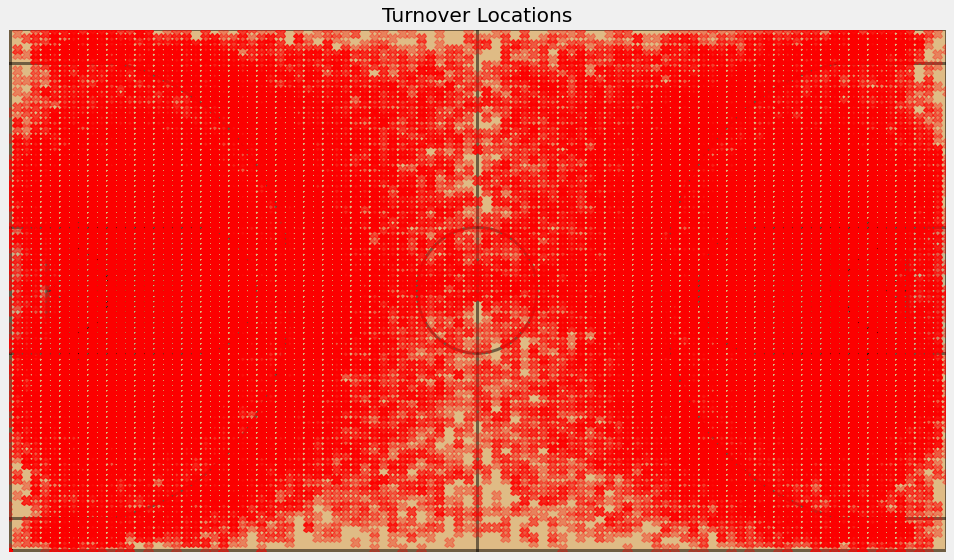

In [29]:
fig, ax = plt.subplots(figsize=(15, 7.8))
ms = 10
ax = create_ncaa_full_court(ax, paint_alpha=0.1)
MEvents.query('EventType == "turnover"').plot(x='X', y='Y', style='X',
          title='Turnover Locations',
          c='red',
          alpha=0.3,
         figsize=(15, 9),
         label='Steals',
         ms=ms,
         ax=ax)
ax.set_xlabel('')
ax.get_legend().remove()
plt.show()

Forcément avec 5 ans de data ça rend pas grand chose ...

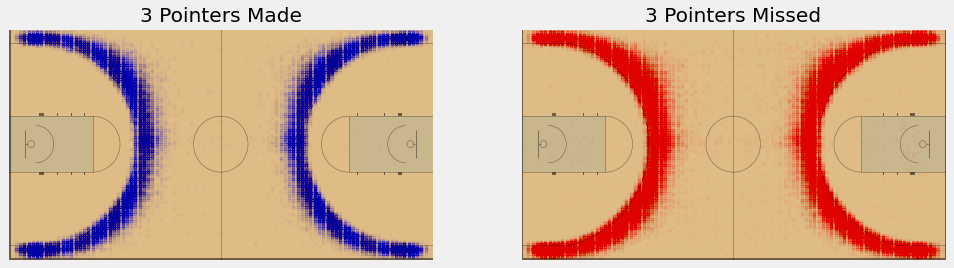

In [30]:
COURT_COLOR = '#dfbb85'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# Where are 3 pointers made from? (This is really cool)
MEvents.query('EventType == "made3"') \
    .plot(x='X', y='Y', style='.',
          color='blue',
          title='3 Pointers Made',
          alpha=0.01, ax=ax1)

ax1 = create_ncaa_full_court(ax1, lw=0.5, three_line='mens', paint_alpha=0.1)
ax1.set_facecolor(COURT_COLOR)
MEvents.query('EventType == "miss3"') \
    .plot(x='X', y='Y', style='.',
          title='3 Pointers Missed',
          color='red',
          alpha=0.01, ax=ax2)

ax2.set_facecolor(COURT_COLOR)
ax2 = create_ncaa_full_court(ax2, lw=0.5, three_line='mens', paint_alpha=0.1)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

In [ ]:
COURT_COLOR = '#dfbb85'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Where are 3 pointers made from? (This is really cool)
MEvents.query('EventType == "made2"') \
    .plot(x='X', y='Y', style='.',
          color='blue',
          title='2 Pointers Made',
          alpha=0.01, ax=ax1)
ax1.set_facecolor(COURT_COLOR)

ax1 = create_ncaa_full_court(ax1, lw=0.5, three_line='mens', paint_alpha=0.1)
MEvents.query('EventType == "miss2"') \
    .plot(x='X', y='Y', style='.',
          title='2 Pointers Missed',
          color='red',
          alpha=0.01, ax=ax2)
ax2.set_facecolor(COURT_COLOR)

ax2 = create_ncaa_full_court(ax2, lw=0.5, three_line='mens', paint_alpha=0.1)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

# PlayerIDs

In [19]:
MPlayers.head()

,PlayerID,LastName,FirstName,TeamID
0,1,Albright,Christian,1101
1,2,Cameron,Tobias,1101
2,3,Cobb,Chase,1101
3,4,Cooke,Austin,1101
4,5,Crnic,Jovan,1101


In [20]:
# Merge Player name onto events
MEvents = MEvents.merge(MPlayers,
              how='left',
              left_on='EventPlayerID',
              right_on='PlayerID')

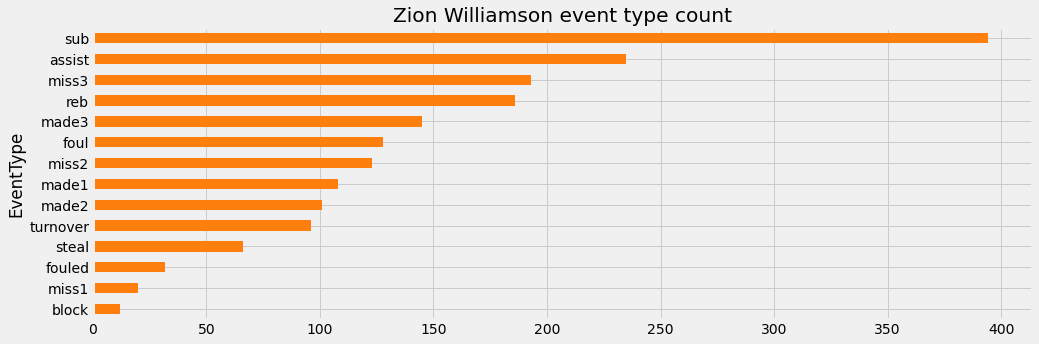

In [21]:
MEvents.loc[MEvents['EventPlayerID'] == 2825].groupby('EventType')['EventID'].count() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Zion Williamson event type count',
          color=mypal[1])
plt.show()

# Plotting Specific Players' Made/Missed Shots

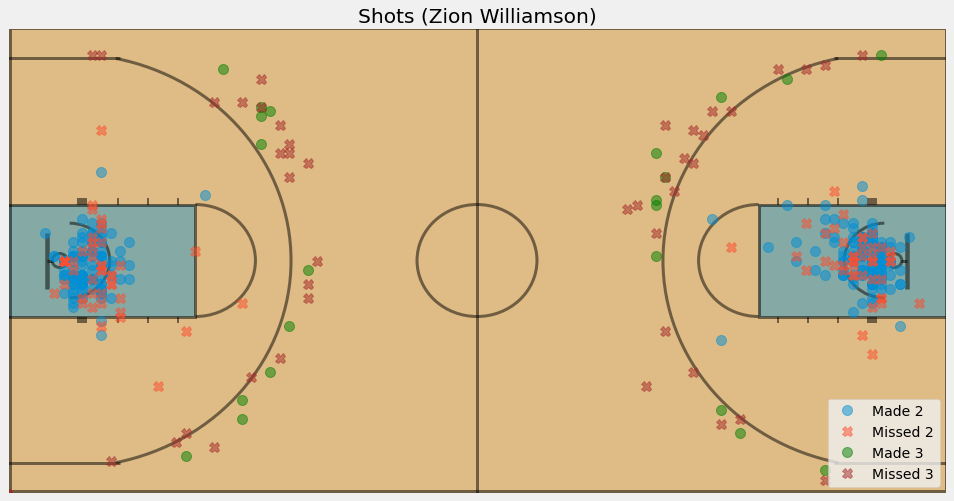

In [22]:
ms = 10 # Marker Size
FirstName = 'Zion'
LastName = 'Williamson'
fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax)
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made2"') \
    .plot(x='X', y='Y', style='o',
          title='Shots (Zion Williamson)',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 2',
         ms=ms,
         ax=ax)
plt.legend()

MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss2"') \
    .plot(x='X', y='Y', style='X',
          alpha=0.5, ax=ax,
         label='Missed 2',
         ms=ms)
plt.legend()

MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made3"') \
    .plot(x='X', y='Y', style='o',
          c='green',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 3', ax=ax,
         ms=ms)
plt.legend()

MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss3"') \
    .plot(x='X', y='Y', style='X',
          c='brown',
          alpha=0.5, ax=ax,
         label='Missed 3',
         ms=ms)

ax.set_xlabel('')
plt.legend()
plt.show()

# Shot Heatmap

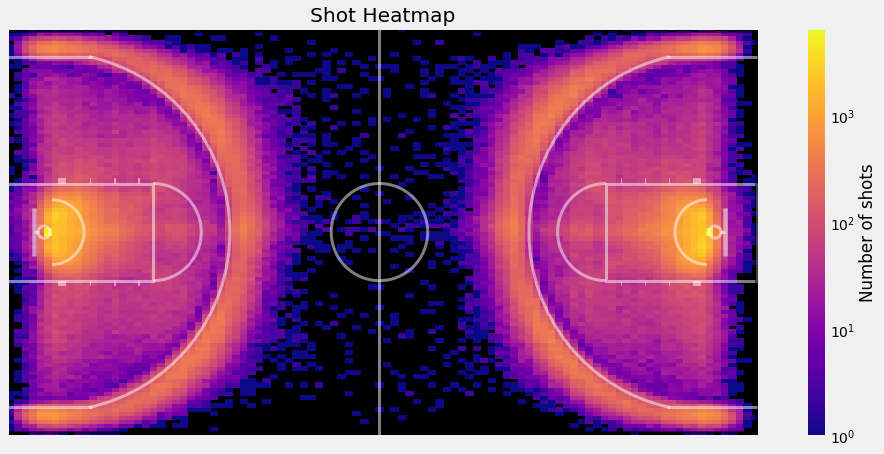

In [23]:
N_bins = 100
shot_events = MEvents.loc[MEvents['EventType'].isin(['miss3','made3','miss2','made2']) & (MEvents['X'] != 0)]
fig, ax = plt.subplots(figsize=(15, 7))
ax = create_ncaa_full_court(ax,
                            paint_alpha=0.0,
                            three_line='mens',
                            court_color='black',
                            lines_color='white')
_ = plt.hist2d(shot_events['X'].values + np.random.normal(0, 0.1, shot_events['X'].shape), 
               # Add Jitter to values for plotting
           shot_events['Y'].values + np.random.normal(0, 0.1, shot_events['Y'].shape),
           bins=N_bins, norm=mpl.colors.LogNorm(),
               cmap='plasma')

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of shots')

ax.set_title('Shot Heatmap')
plt.show()

# Création de la variable 'MatchID'

In [34]:
MEvents = data["MEvents"]
pd.set_option('display.max_columns', None)
MEvents.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area,counter,Area_Name
0,1,2015,11,1103,1420,74,57,0,0,19,1103,112,miss3,unk,0.0,0.0,0,1,NaN
1,2,2015,11,1103,1420,74,57,0,0,19,1420,13747,reb,def,0.0,0.0,0,1,NaN
2,3,2015,11,1103,1420,74,57,0,2,27,1420,13753,made2,dunk,0.0,0.0,0,1,NaN
3,4,2015,11,1103,1420,74,57,0,2,27,1420,13770,assist,NaN,0.0,0.0,0,1,NaN
4,5,2015,11,1103,1420,74,57,2,2,59,1103,98,made2,jump,0.0,0.0,0,1,NaN


In [35]:
b = MEvents[486:500]
b
# Il semblerait qu'on soit face à un nouveau match lorsque WcurrentScore (ou LCurrentScore) repart à 0
# Les lignes précédentes correspondant aux différentes actions d'un même match

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area,counter,Area_Name
486,487,2015,11,1103,1420,74,57,74,55,2388,1420,0,reb,off,0.0,0.0,0,1,NaN
487,488,2015,11,1103,1420,74,57,74,57,2389,1420,13749,made2,lay,0.0,0.0,0,1,NaN
488,489,2015,11,1104,1406,82,54,0,0,4,1406,13121,miss2,lay,0.0,0.0,0,1,NaN
489,490,2015,11,1104,1406,82,54,0,0,4,1104,138,block,NaN,0.0,0.0,0,1,NaN
490,491,2015,11,1104,1406,82,54,0,0,6,1406,13121,reb,off,0.0,0.0,0,1,NaN
491,492,2015,11,1104,1406,82,54,0,0,9,1406,13143,miss3,unk,0.0,0.0,0,1,NaN
492,493,2015,11,1104,1406,82,54,0,0,9,1104,165,reb,def,0.0,0.0,0,1,NaN
493,494,2015,11,1104,1406,82,54,0,0,22,1104,173,foul,unk,0.0,0.0,0,1,NaN
494,495,2015,11,1104,1406,82,54,0,0,22,1104,173,turnover,unk,0.0,0.0,0,1,NaN
495,496,2015,11,1104,1406,82,54,0,0,32,1104,173,foul,unk,0.0,0.0,0,1,NaN


In [ ]:
# On créé la variable MatchID et on met des 1 sur l'échantillon 
b.insert(0,'MatchID',1)
b

In [26]:
# On créé la variable MatchID et on met des 1 sur l'échantillon 
b.insert(0,'MatchID',1)
b

,MatchID,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area,counter,Area_Name
486,1,487,2015,11,1103,1420,74,57,74,55,2388,1420,0,reb,off,0.0,0.0,0,1,NaN
487,1,488,2015,11,1103,1420,74,57,74,57,2389,1420,13749,made2,lay,0.0,0.0,0,1,NaN
488,1,489,2015,11,1104,1406,82,54,0,0,4,1406,13121,miss2,lay,0.0,0.0,0,1,NaN
489,1,490,2015,11,1104,1406,82,54,0,0,4,1104,138,block,NaN,0.0,0.0,0,1,NaN
490,1,491,2015,11,1104,1406,82,54,0,0,6,1406,13121,reb,off,0.0,0.0,0,1,NaN
491,1,492,2015,11,1104,1406,82,54,0,0,9,1406,13143,miss3,unk,0.0,0.0,0,1,NaN
492,1,493,2015,11,1104,1406,82,54,0,0,9,1104,165,reb,def,0.0,0.0,0,1,NaN
493,1,494,2015,11,1104,1406,82,54,0,0,22,1104,173,foul,unk,0.0,0.0,0,1,NaN
494,1,495,2015,11,1104,1406,82,54,0,0,22,1104,173,turnover,unk,0.0,0.0,0,1,NaN
495,1,496,2015,11,1104,1406,82,54,0,0,32,1104,173,foul,unk,0.0,0.0,0,1,NaN
